In [18]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [12]:
class Value:    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
        self._backward = lambda: None  # function to be defined later
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad 
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out
    
    def __rmul__(self, other): # other * self
        return  self * other
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __pow__(self, other): # self ** other
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data**(other -1)) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    #def exp(self):
    # but for educational purpose:
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
            
        return out
    
    def backward(self):
        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [4]:
!pip install graphviz
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [ ]:
## Neuron valuaes:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias b
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'out'

print(o)

Value(data=0.8813735870195432)


In [6]:
# topological sort
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

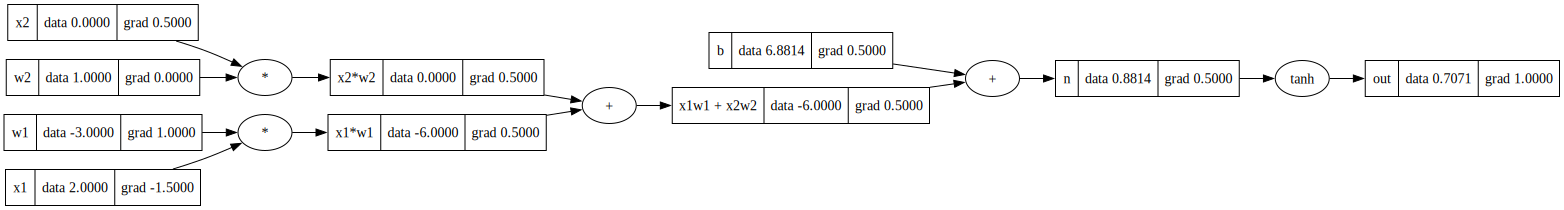

In [9]:
draw_dot(o)

In [8]:
o.backward()

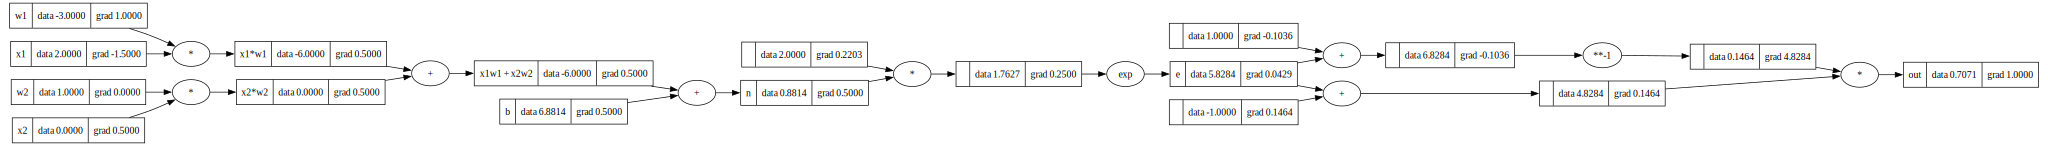

In [13]:
## Neuron valuaes:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias b
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# -----
e = (2*n).exp(); e.label='e'
o = (e - 1) / (e + 1); o.label = 'out'
# -----
o.backward()
draw_dot(o)

In [15]:
!pip install torch
import torch

  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached MarkupSafe-3.0.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (4.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 MB 11.5 MB/s eta 0:00:0000:0100:01
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)
Using cached networkx-3.5-py3-none-any.whl (2.0 MB)
Using cached MarkupSafe-3.0.2-cp312-cp312-macosx_11_0_arm64.whl (12 kB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)


In [17]:
x1 = torch.Tensor([2.0]).double()               ; x1.requires_grad = True
w1 = torch.Tensor([-3.0]).double()              ; w1.requires_grad = True
x2 = torch.Tensor([0.0]).double()               ; x2.requires_grad = True
w2 = torch.Tensor([1.0]).double()               ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('-----')
print('x2.grad:', x2.grad.item())
print('w2.grad:', w2.grad.item())
print('x1.grad:', x1.grad.item())
print('w1.grad:', w1.grad.item())

0.7071066904050358
-----
x2.grad: 0.5000001283844369
w2.grad: 0.0
x1.grad: -1.5000003851533106
w1.grad: 1.0000002567688737


In [77]:
class Neuron:
    def __init__(self, nin):
    # nin: number of inputs
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        # w * x + b
        """
        the way it works: 
        let's say we have x = [2.0, 3.0]
        and n = Neuron(2)
        then n(x) will call __call__ with x as input
        and inside __call__, we will do a dot product of w and x
        and add the bias b
        and then apply the activation function (tanh here)
        and return the output
        """
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        # nin: number of inputs
        # nout: number of outputs
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        # x: input vector
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        """
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params
        """
        
class MLP: # Multi-Layer Perceptron
    def __init__(self, nin, nouts):
        # nin: number of inputs
        # nouts: list of number of outputs for each layer
        sz = [nin] + nouts
        # we just iterate over pairs of sizes to create list of those layers
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        

In [429]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.22566501677996126)

In [430]:
n.parameters()

[Value(data=-0.12504065959366528),
 Value(data=0.16550133513523457),
 Value(data=-0.6093575949048293),
 Value(data=0.13929332047315013),
 Value(data=0.3645065590476142),
 Value(data=0.4152389421817033),
 Value(data=0.2180860060296428),
 Value(data=-0.6584987710619856),
 Value(data=0.09144588355433725),
 Value(data=0.6438477101754816),
 Value(data=0.015174607094974757),
 Value(data=-0.7395350746831548),
 Value(data=0.6728780704720243),
 Value(data=0.38101534963204986),
 Value(data=0.8507471185137505),
 Value(data=-0.823750040776779),
 Value(data=0.6067340639951044),
 Value(data=0.5084077135093412),
 Value(data=-0.35893924485788276),
 Value(data=-0.348929840410241),
 Value(data=0.3372263336776429),
 Value(data=0.6368376001815761),
 Value(data=-0.35975227066029847),
 Value(data=0.9650935475724853),
 Value(data=-0.9867864260642278),
 Value(data=0.853629586339169),
 Value(data=-0.8411399399835686),
 Value(data=-0.048107383252727676),
 Value(data=-0.1668168792448983),
 Value(data=-0.38279173

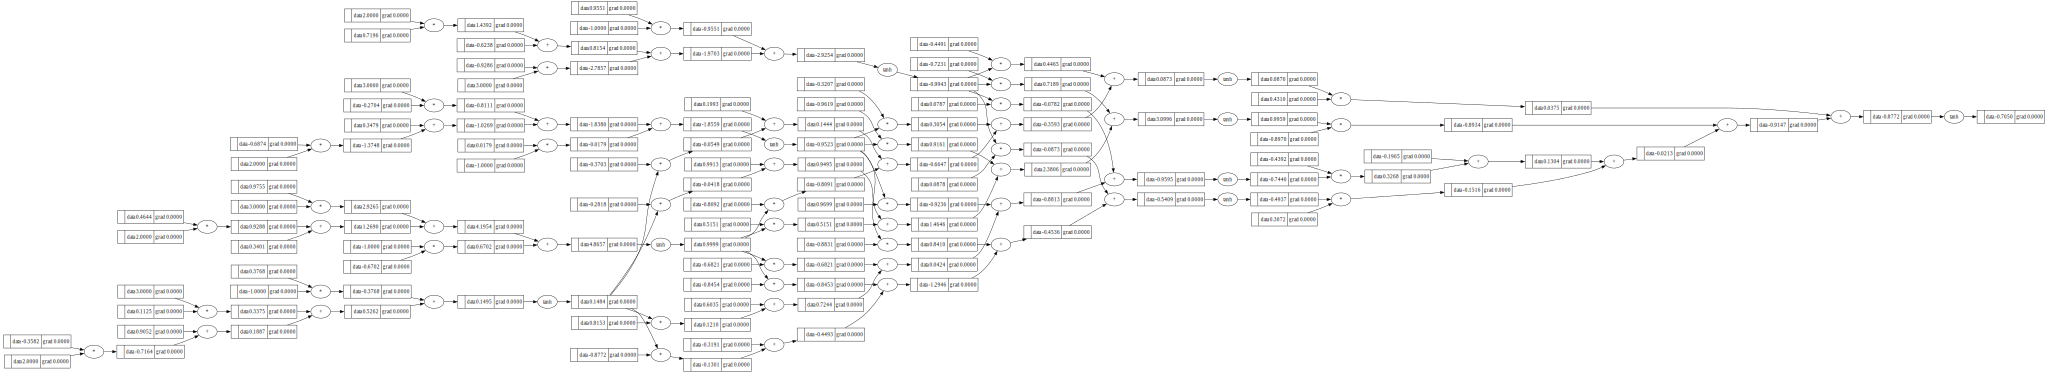

In [80]:
draw_dot(n(x))

In [431]:
# create a very simple dataset example
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # expected outputs

ypred = [n(x) for x in xs]

In [432]:
ypred

[Value(data=0.22566501677996126),
 Value(data=-0.007479231671564022),
 Value(data=0.3010681631262534),
 Value(data=0.0034309143093409077)]

In [424]:
# Now we tune the weights of the network to make ypred match ys

# Let's implememt the mean squared error (MSE) loss function
loss = Value(0.0)
for value in [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]:
    loss += value
loss



Value(data=9.001637047544726)

In [84]:
loss.backward()

In [423]:
n.layers[0].neurons[0].w[0].grad

0.0

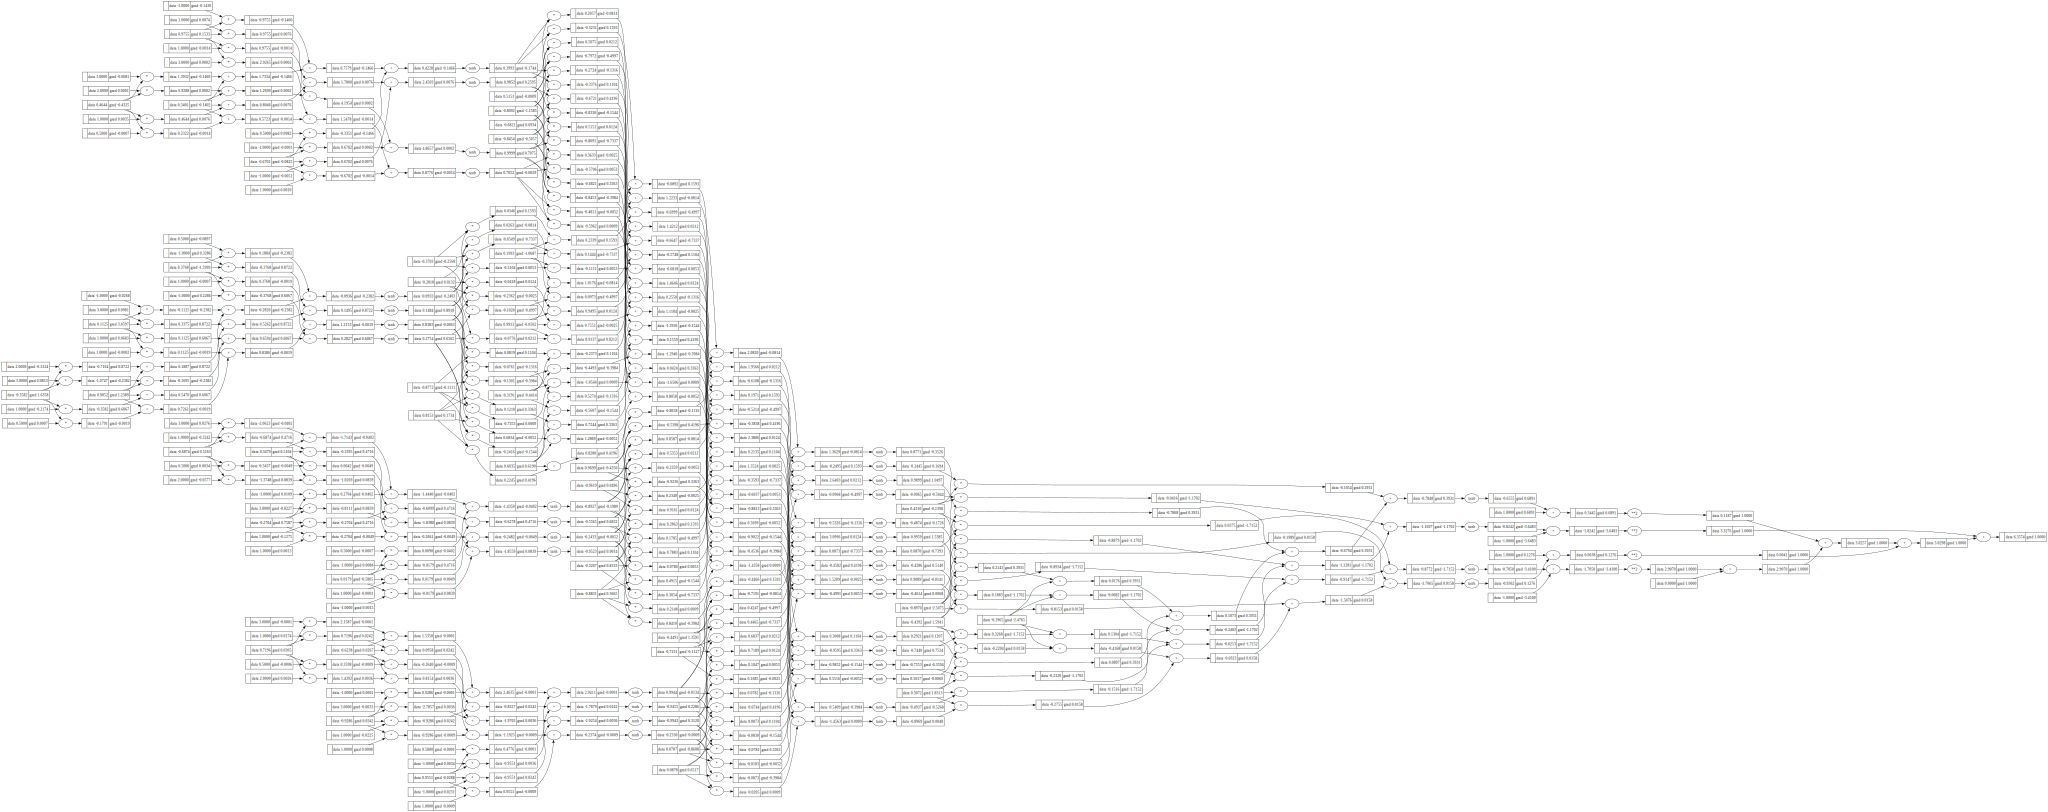

In [86]:
draw_dot(loss)

In [325]:
n.layers[0].neurons[0].w[0].data

-0.0695506912063096

In [427]:
n.layers[0].neurons[0].w[0].grad

2.794505893553247

In [439]:
for k in range(20):
    # forward pass:
    ypred = [n(x) for x in xs]
    loss = Value(0.0)
    for value in [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]:
        loss += value
    
    # backward pass:
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update weights
    for p in n.parameters():
        p.data += -0.05 * p.grad
    
    print(f"epoch {k}: loss {loss.data}")

epoch 0: loss 0.004998327263502864
epoch 1: loss 0.004940882642690669
epoch 2: loss 0.0048846784479300645
epoch 3: loss 0.004829675844743513
epoch 4: loss 0.004775837581554676
epoch 5: loss 0.004723127910546826
epoch 6: loss 0.004671512513193971
epoch 7: loss 0.004620958430147448
epoch 8: loss 0.004571433995185005
epoch 9: loss 0.004522908772951223
epoch 10: loss 0.00447535350023939
epoch 11: loss 0.004428740030582837
epoch 12: loss 0.004383041281940983
epoch 13: loss 0.004338231187281392
epoch 14: loss 0.004294284647873181
epoch 15: loss 0.004251177489120759
epoch 16: loss 0.004208886418778616
epoch 17: loss 0.0041673889873995295
epoch 18: loss 0.004126663550878786
epoch 19: loss 0.004086689234966372


In [409]:
loss.backward()

In [410]:
for p in n.parameters():
    p.data += -0.0001 * p.grad
    

In [440]:
ypred 

[Value(data=0.9698279868362197),
 Value(data=-0.9781030700724336),
 Value(data=-0.9573615919405021),
 Value(data=0.9703549418197563)]